In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Dataset and Settings

In [2]:
ARCH = 'mlp'
MODIFIED_SGD = True
SAVE = True

In [3]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 100        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(60000.0/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.1
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)
    in_size    = 784
    out_size   = 10

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, ARCH, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, ARCH, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET, ARCH, 'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, ARCH, 'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

In [5]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd

from mlp_archs import MLP
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=mb_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=mb_size, shuffle=True, **kwargs)

In [8]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


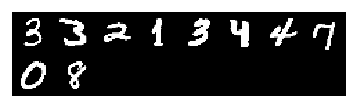

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [10]:
F.tanh

<function torch.nn.functional.tanh>

### Check labelling

Useful in case of random shuffling of labels

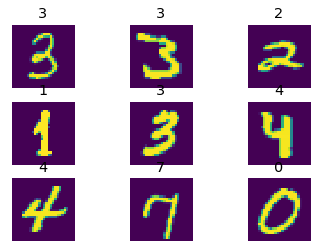

In [11]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

In [12]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.view(mb_size,-1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [13]:
# define architecture
h_sizes = [in_size,100,100]

In [14]:
model = MLP(h_sizes=h_sizes, 
            out_size=out_size, 
            actfun=F.tanh)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [15]:
?F.cross_entropy

Signature: F.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)
Docstring:
This criterion combines `log_softmax` and `nll_loss` in a single
function.

See :class:`~torch.nn.CrossEntropyLoss` for details.

Args:
    input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K > 1`
        in the case of K-dimensional loss.
    target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): By default, the losses are averaged
            over observations for each minibatch. However, if the field
            :attr:`size_average` is set to ``False``, the l

In [16]:
?F.nll_loss

Signature: F.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)
Docstring:
The negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K > 1`
        in the case of K-dimensional loss.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): By default, the losses are averaged
        over observations for each minibatch. If :attr:`size_average`
        is ``False``, the losses are summed for each minibatch. Default: ``True``
    ignore_index (int, optional): Specifies a target value

In [17]:
?model.state_dict

Signature: model.state_dict(destination=None, prefix='', keep_vars=False)
Docstring:
Returns a dictionary containing a whole state of the module.

Both parameters and persistent buffers (e.g. running averages) are
included. Keys are corresponding parameter and buffer names.

Returns:
    dict:
        a dictionary containing a whole state of the module

Example::

    >>> module.state_dict().keys()
    ['bias', 'weight']
File:      ~/.local/envs/pytorch/lib/python3.5/site-packages/torch/nn/modules/module.py
Type:      method


In [18]:
model.state_dict().keys()

odict_keys(['hidden.0.weight', 'hidden.0.bias', 'hidden.1.weight', 'hidden.1.bias', 'out.weight', 'out.bias'])

In [19]:
model.state_dict()['hidden.0.weight'].size()

torch.Size([100, 784])

In [20]:
print(model)
print( summary(model, (in_size,)  ) )

MLP(
  (hidden): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           78500
            Linear-2                  [-1, 100]           10100
            Linear-3                   [-1, 10]            1010
Total params: tensor(89610)
Trainable params: tensor(89610)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [21]:
train_stats = []
test_stats  = []
fractions   = []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(5)):
    
    if epoch == 0:
        # get statistics
        tr = get_stats(train_loader)
        ts = get_stats(test_loader)

        # print statistics
        print('Initial train loss : %g --- Initial train acc : %g %%' % ( tr[0], tr[1] )) 
        print('Initial test  loss : %g --- Initial test  acc : %g %%' % ( ts[0],  ts[1] ))         

    
    # init accumulators grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    for i, data in enumerate(train_loader, 0):
                       
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(mb_size,-1)
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 : 
            
            # compute the snr 
            snr = compute_snr(grad, grad2, n)
            
            # temper the grad with the information on grad2
            fr = []
            with torch.no_grad():
                for p, g, s in zip(model.parameters(), grad, snr): 
                    
                    
                    # this is the only line where the true gradient is touched
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g/n, s * g/n)          
                    else:
                        p.grad = g/n
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)
    
            # store statistics about grad, grad2 and snr    
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  0%|          | 0/5 [00:00<?, ?it/s]

Initial train loss : 0.22783 --- Initial train acc : 15.7383 %
Initial test  loss : 0.227679 --- Initial test  acc : 15.92 %


 20%|██        | 1/5 [00:15<01:03, 15.76s/it]

Train loss : 0.0508528 --- Train acc : 88.23 %
Test  loss : 0.0494014 --- Test  acc : 88.77 %


 40%|████      | 2/5 [00:26<00:39, 13.18s/it]

Train loss : 0.0356254 --- Train acc : 90.4617 %
Test  loss : 0.0345014 --- Test  acc : 90.83 %


 60%|██████    | 3/5 [00:36<00:24, 12.31s/it]

Train loss : 0.0303546 --- Train acc : 91.5433 %
Test  loss : 0.0295887 --- Test  acc : 91.96 %


 80%|████████  | 4/5 [00:47<00:11, 11.84s/it]

Train loss : 0.0272595 --- Train acc : 92.2483 %
Test  loss : 0.0267146 --- Test  acc : 92.56 %


100%|██████████| 5/5 [00:58<00:00, 11.68s/it]

Train loss : 0.0247721 --- Train acc : 92.99 %
Test  loss : 0.0245457 --- Test  acc : 93.1 %


In [22]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions' ]
vals = [train_stats, test_stats, fractions]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


ValueError: x and y must have same first dimension, but have shapes (6000,) and (300,)

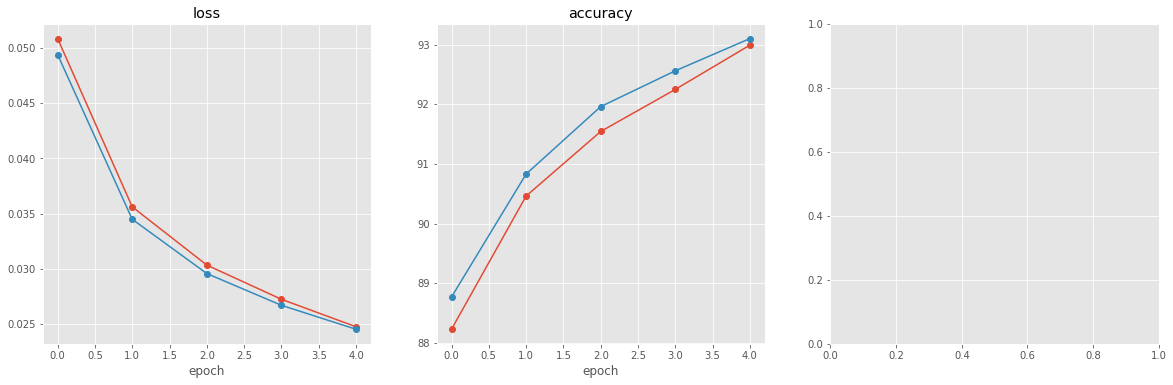

In [23]:
win = 30
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ][1:]

fig = plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.plot(train_stats[:,0],'-o',label='training loss')
plt.plot(test_stats[:,0],'-o',label='test loss')
plt.xlabel('epoch')
plt.title('loss')


plt.subplot(3,3,2)
plt.plot(train_stats[:,1],'-o',label='training accuracy')
plt.plot(test_stats[:,1],'-o',label='test accuracy')
plt.xlabel('epoch')
plt.title('accuracy')


plt.subplot(3,3,3)
for i in range(len(layer_names)):
    plt.plot(np.arange(n_lb*epochs), pd.rolling_mean(fractions[:,i*2], win*2 ),label=layer_names[i])

plt.legend()
plt.xlabel('epoch')
plt.title('fractions')


plt.subplot(3,3,4)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad mean')

plt.subplot(3,3,5)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad std')

plt.subplot(3,3,6)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad2 mean')

plt.subplot(3,3,7)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad2 std')


plt.subplot(3,3,8)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('snr mean')

plt.subplot(3,3,9)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('snr std')


plt.savefig(os.path.join(FIG, 'mnist.png'))

    
plt.show()